GE21-FOIL-M3-G3-KR-B02-0008
GE21-FOIL-M3-G12-KR-B02-0022
GE21-FOIL-M3-G12-KR-B02-0021
GE21-FOIL-M3-G3-KR-B02-0001
GE21-FOIL-M3-G12-KR-B02-0015
GE21-FOIL-M3-G3-KR-B02-0010
GE21-FOIL-M3-G12-KR-B02-0016
GE21-FOIL-M3-G12-KR-B02-0011
GE21-FOIL-M3-G12-KR-B02-0025
GE21-FOIL-M3-G3-KR-B02-0006
GE21-FOIL-M3-G3-KR-B02-0004
GE21-FOIL-M3-G12-KR-B02-0017
GE21-FOIL-M3-G12-KR-B02-0020
GE21-FOIL-M3-G3-KR-B02-0009
GE21-FOIL-M3-G12-KR-B02-0023


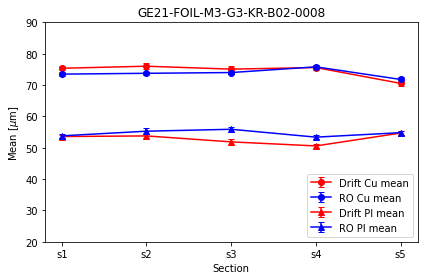

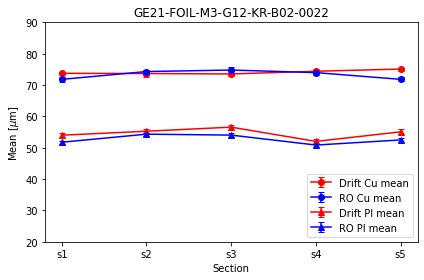

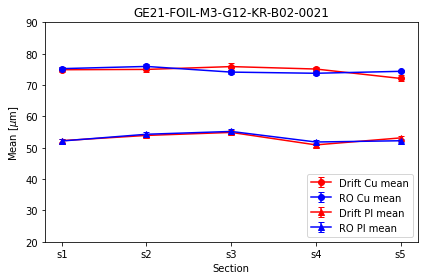

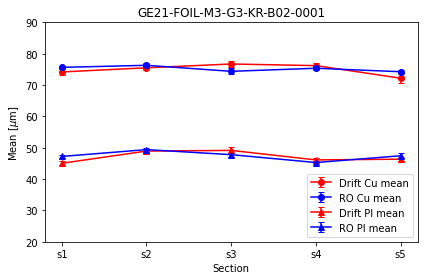

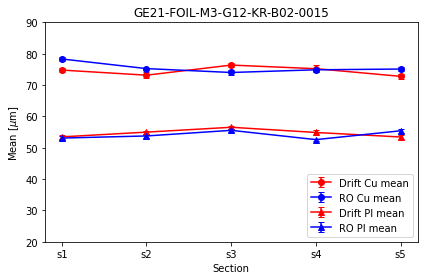

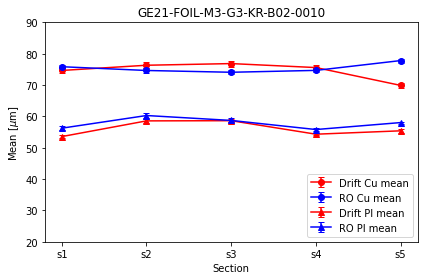

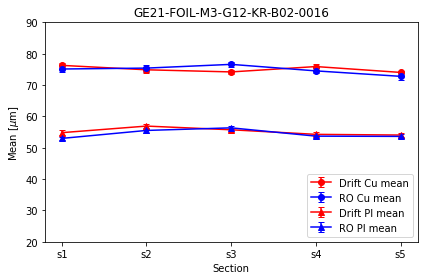

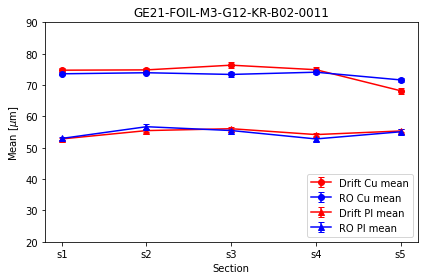

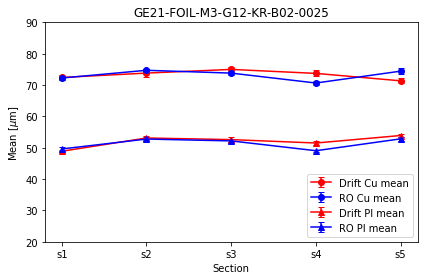

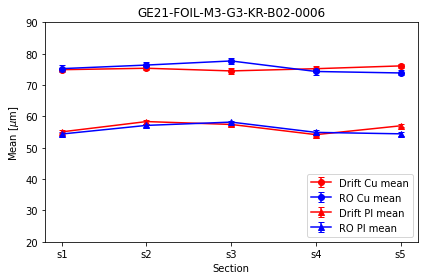

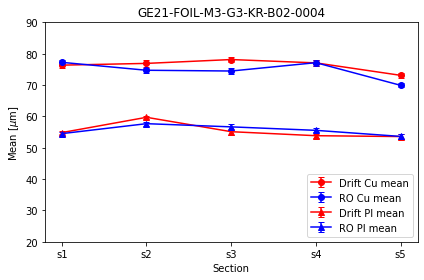

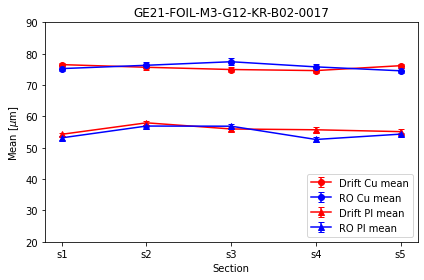

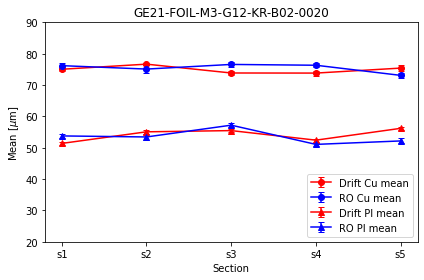

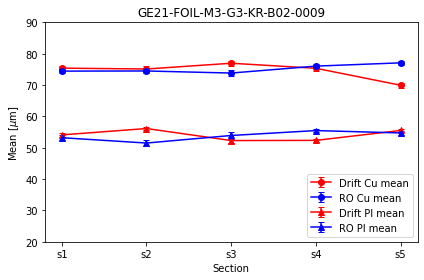

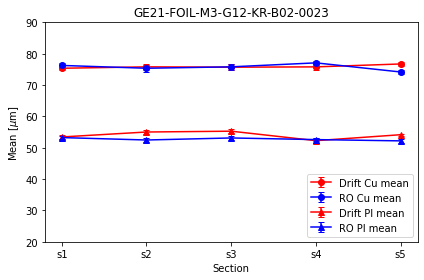

In [47]:
import os
from math import isnan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
##### edit case by case #####
path_data = ".data/M3_Batch_2"
path_saved = ".results/M3_Batch_2/Hole_Diameters"

if not os.path.exists(path_saved):
    os.makedirs(path_saved)

##### read directories #####
dirs = os.listdir(path_data)

##### helper functions #####
def read_data(excel):
    inspections = {
        "s1_Cu": [],
        "s1_PI": [],
        "s2_Cu": [],
        "s2_PI": [],
        "s3_Cu": [],
        "s3_PI": [],
        "s4_Cu": [],
        "s4_PI": [],
        "s5_Cu": [],
        "s5_PI": []
    }

    keys = list(inspections.keys())
    k_iter = iter(keys)
    for idx in excel.index:
        label, value = excel.iloc[idx, 0], excel.iloc[idx, 1]
        #print(df.iloc[idx, 0], type(df.iloc[idx, 0]), df.iloc[idx, 1], type(df.iloc[idx, 1]))
        if type(label) == str and label == "Obj #" and value == "Diameter":
            key = next(k_iter)
        elif type(label) != str and not isnan(label) and not isnan(value):
            inspections[key].append(value)
        elif type(label) == str:
            is_summary = True
        elif isnan(label):
            is_blank = True
        else:
            print(excel.iloc[idx, 0], excel.iloc[idx, 1])

    return inspections


def analyze(inspections):
    # return means and stds for each section
    Cu_means = []
    Cu_stds = []
    PI_means = []
    PI_stds = []

    for key in inspections.keys():
        if "Cu" in key:
            Cu = np.array(inspections[key])
            Cu_means.append(round(Cu.mean(), 2))
            Cu_stds.append(round(Cu.std(), 2))
        elif "PI" in key:
            PI = np.array(inspections[key])
            PI_means.append(round(PI.mean(), 2))
            PI_stds.append(round(PI.std(), 2))

    return Cu_means, Cu_stds, PI_means, PI_stds

sections = ['s1', 's2', 's3', 's4', 's5']
dirs = [d for d in os.listdir(path_data) if "M" in d and len(d.split("_")[-1]) == 5]
drift_total_ins = {}
RO_total_ins = {}
for d in dirs:
    info = d.split("_")
    foil_num = int(d[-4:-1])
    foil_type = "12" if d[-1] == "A" else "3"
    title = f"GE21-FOIL-{info[0]}-G{foil_type}-KR-B{info[1]}-{'0'*(4-len(str(foil_num)))}{foil_num}"
    print(title)
    # read excels
    drift_ins = read_data(pd.read_excel(
        f"{path_data}/{d}/D_Hole_Ins/D_Hole_Diameter_Inspection.xlsx", header=None))
    RO_ins = read_data(pd.read_excel(
        f"{path_data}/{d}/RO_Hole_Ins/RO_Hole_Diameter_Inspection.xlsx", header=None))
    # 
    D_Cu_means, D_Cu_stds, D_PI_means, D_PI_stds = analyze(drift_ins)
    RO_Cu_means, RO_Cu_stds, RO_PI_means, RO_PI_stds = analyze(RO_ins)
    drift_total_ins[f"{foil_num}_CUMean"] = D_Cu_means
    drift_total_ins[f"{foil_num}_CUStdev"] = D_Cu_stds
    drift_total_ins[f"{foil_num}_PIMean"] = D_PI_means
    drift_total_ins[f"{foil_num}_PIStdev"] = D_Cu_stds
    RO_total_ins[f"{foil_num}_CUMean"] = RO_Cu_means
    RO_total_ins[f"{foil_num}_CUStdev"] = RO_Cu_stds
    RO_total_ins[f"{foil_num}_PIMean"] = RO_Cu_means
    RO_total_ins[f"{foil_num}_PIStdev"] = RO_Cu_stds
        
    fig, ax = plt.subplots()
    plt.errorbar(sections, D_Cu_means, D_Cu_stds, marker="o",
                     color="red", capsize=3, label="Drift Cu mean")
    plt.errorbar(sections, RO_Cu_means, RO_Cu_stds, marker="o",
                     color="blue", capsize=3, label="RO Cu mean")
    plt.errorbar(sections, D_PI_means, D_PI_stds, marker="^",
                     color="red", capsize=3, label="Drift PI mean")
    plt.errorbar(sections, RO_PI_means, RO_PI_stds, marker="^",
                     color="blue", capsize=3, label="RO PI mean")

    plt.xticks(sections)
    plt.title(title)
    plt.xlabel("Section")
    plt.ylabel(r"Mean [$\mu$m]")
    plt.ylim(20, 90)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(f"{path_saved}/F{foil_num}_diameter.png")

In [68]:
def deco(total_ins):
    df = pd.DataFrame(data=total_ins).transpose()
    df.set_axis(['1', '2', '3', '4', '5'], axis=1, inplace=True)

    CU = df.copy()
    for idx in CU.index:
        if "PI" in idx:
            CU.drop(labels=idx, inplace=True)
    CU["tmp_idx"] = 0.
    CU["index"] = CU.index
    CU["Mean"] = 0.
    for i, idx in enumerate(CU.index):
        if "Mean" in idx:
            CU.loc[idx, "tmp_idx"] = int(idx.split("_")[0])+0.1
            CU.loc[idx, "Mean"] = round(CU.iloc[i, :5].mean(), 2)
        elif "Stdev" in idx:
            CU.loc[idx, "tmp_idx"] = int(idx.split("_")[0])+0.2
            CU.loc[idx, "Mean"] = round(CU.iloc[i-1, :5].std(), 2)
        else:
            print(idx)
    CU.set_index("tmp_idx", inplace=True)
    CU.sort_index(inplace=True)
    CU.set_index("index", inplace=True)
    CU.index.name = "Foil | Section"

    PI = df.copy()
    for idx in PI.index:
        if "CU" in idx:
            PI.drop(labels=idx, inplace=True)
    PI["tmp_idx"] = 0.
    PI["index"] = PI.index
    PI["Mean"] = 0.
    for i, idx in enumerate(PI.index):
        if "Mean" in idx:
            PI.loc[idx, "tmp_idx"] = int(idx.split("_")[0])+0.1
            PI.loc[idx, 'Mean'] = round(PI.iloc[i, :5].mean(), 2)
        elif "Stdev" in idx:
            PI.loc[idx, "tmp_idx"] = int(idx.split("_")[0])+0.2
            PI.loc[idx, 'Mean'] = round(PI.iloc[i-1, :5].std(), 2)
        else:
            print(idx)
    PI.set_index("tmp_idx", inplace=True)
    PI.sort_index(inplace=True)
    PI.set_index("index", inplace=True)
    PI.index.name = "Foil | Section"
    return CU, PI

dCU, dPI = deco(drift_total_ins)
rCU, rPI = deco(RO_total_ins)

with pd.ExcelWriter("test.xlsx", mode="a", if_sheet_exists="overlay") as writer:
    dCU.to_excel(writer, startrow=0, sheet_name="Drift")
    dPI.to_excel(writer, startrow=len(dCU)+3, sheet_name="Drift")
    rCU.to_excel(writer, startrow=0, sheet_name="RO")
    rPI.to_excel(writer, startrow=len(rCU)+3, sheet_name="RO")

In [72]:
# finalize the plots
def get_arrays(df):
    mean = []
    std = []
    for i, idx in enumerate(df.index):
        if "Mean" in idx:
            mean.append(df.iloc[i, 5])
        else:
            std.append(df.loc[i, 5])
    assert len(mean) == len(std)
    
    return mean, std
        

foil_num = []


['1', '4', '6', '8', '9', '10', '11', '15', '16', '17', '20', '21', '22', '23', '25']
[74.97, 76.32, 75.23, 74.52, 74.56, 74.67, 73.81, 74.47, 75.06, 75.6, 74.97, 74.61, 74.11, 75.89, 73.27]
[1.82, 1.91, 0.6, 2.25, 2.68, 2.79, 3.21, 1.49, 1.01, 0.8, 1.19, 1.45, 0.65, 0.51, 1.4]
[47.13, 55.42, 56.42, 52.91, 54.09, 56.11, 54.79, 54.67, 55.16, 55.83, 54.12, 53.04, 54.6, 54.04, 52.01]
[1.83, 2.49, 1.73, 1.65, 1.76, 2.38, 1.29, 1.28, 1.18, 1.36, 2.09, 1.53, 1.7, 1.23, 1.95]
